In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
class AdaBoost:
    '''
    Implementation of AdaBoost
    Typically, for labels we use {-1, 1}. This implementation was made in such
    a way, that labels {0, 1} will work as well
    '''
    def __init__(self, B, base_learner_factory=None):
        '''
        B: int -  number of classifiers
        base_learner_factory: function - function creating and returning
            base learner model, by default function creating stump
        '''
        self.B = B
        self.base_learner_factory = base_learner_factory
        if base_learner_factory is None:
            def create_stump():
                model = DecisionTreeClassifier(max_depth=1)
                return model
            self.base_learner_factory = create_stump
        self.ensemble = None
    
    def predict(self, X, num_ensembles=None):
        if num_ensembles == None:
            num_ensembles = len(self.ensemble)
        num_ensembles = max(0, num_ensembles)
        num_ensembles = min(num_ensembles, len(self.ensemble))
        ensemble = self.ensemble[:num_ensembles]

        y_pred = []
        for i in range(len(ensemble)):
            y_pred_i = self.ensemble[i][0].predict(X)
            y_pred.append(y_pred_i)
        y_pred = np.vstack(y_pred).T

        betas = np.array([x[1] for x in ensemble])
        classes = np.unique(y_pred)
        y_cls = []
        for cls in classes:
            y_cls_val = np.sum(
                (y_pred == cls).astype(int) * np.log(1 / betas), 
                axis=1
                )
            y_cls.append(y_cls_val)
        y_cls = np.vstack(y_cls)
        
        y_pred = classes[np.argmax(y_cls, axis=0)]
        return y_pred

    def fit(self, X, y):
        self.ensemble = []
        w = np.ones(len(y)) / len(y)
        for i in range(self.B):
            bl = self.base_learner_factory()
            bl.fit(X, y, w)
            y_train_pred = bl.predict(X)
            fail_idx = y != y_train_pred
            eps = w[fail_idx].sum()
            beta = eps / (1 - eps)
            self.ensemble.append((bl, beta))
            w[~fail_idx] *= beta
            w /= w.sum()

In [3]:
# create artificial dataset

df = 10 # degrees of freedom
n = 12000 # number of samples

X_artificial = np.pow(np.random.normal(size=(n, df)), 2)
chi2_median = chi2.ppf(0.5, df)
y_artificial = (X_artificial.sum(axis=1) > chi2_median).astype(int) #* 2 - 1

# train test split
(
    X_artificial_train, 
    X_artificial_test, 
    y_artificial_train, 
    y_artificial_test
) = train_test_split(
    X_artificial, 
    y_artificial, 
    shuffle=True, 
    train_size=10000
    )

In [10]:
# preprocessing of a dataset containing information about student performance
# link: https://archive.ics.uci.edu/dataset/320/student+performance
# our goal is to predict, if student has high 'G1' value or not
# by high G1 value, we mean value higher than median of column 'G1'
# we also drop column 'G2' and 'G3'

df_math = pd.read_csv(
    os.path.join('student+performance', 'student', 'student-mat.csv'),
    sep=';'
    )
df_math.drop(columns=['G2', 'G3'], inplace=True)

# encode categorical data
str_cols = df_math.columns[df_math.dtypes == 'object']
for str_col in str_cols:
    dummy_encoder = LabelEncoder()
    df_math[str_col] = dummy_encoder.fit_transform(df_math[str_col])

# split into X and y
X_real, y_real = df_math.drop(columns='G1').to_numpy(), df_math['G1'].to_numpy()

# 1 is good performance of student, 0 is bad performance
y_real = (y_real > round(np.median(y_real))).astype(int)
y_encoder = LabelEncoder()
y_real = y_encoder.fit_transform(y_real)

In [11]:
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(X_real, y_real, train_size=0.8)

In [6]:
def eval_classifiers(num_classifiers: int, max_depth: int, X_train, X_test, y_train, y_test):
    data = {}
    num_classifiers = range(1, num_classifiers+1)

    single_tree = DecisionTreeClassifier(max_depth=max_depth)
    single_tree.fit(X_train, y_train)
    st_pred = single_tree.predict(X_test)
    data['Single tree'] = {'Test Accuracy': [(st_pred == y_test).astype(int).mean()]}

    bagging_test_accuracy = []
    bagging_train_accuracy = []
    adaboost_test_accuracy = []
    adaboost_train_accuracy = []
    xgboost_test_accuracy = []
    xgboost_train_accuracy = []
    rf_test_accuracy = []
    rf_train_accuracy = []

    for nc in num_classifiers:
        #print(nc)
        bag_cls = BaggingClassifier(n_estimators=nc, estimator=DecisionTreeClassifier(max_depth=max_depth))
        bag_cls.fit(X_train, y_train)
        bag_pred = bag_cls.predict(X_test)
        bag_train_pred = bag_cls.predict(X_train)
        bagging_test_accuracy.append((bag_pred == y_test).astype(int).mean())
        bagging_train_accuracy.append((bag_train_pred == y_train).astype(int).mean())

        ada_clf = AdaBoost(nc, lambda: DecisionTreeClassifier(max_depth=max_depth))
        ada_clf.fit(X_train, y_train)
        ada_pred = ada_clf.predict(X_test)
        ada_train_pred = ada_clf.predict(X_train)
        adaboost_test_accuracy.append((ada_pred == y_test).astype(int).mean())
        adaboost_train_accuracy.append((ada_train_pred == y_train).astype(int).mean())

        xgb_clf = xgb.XGBClassifier(n_estimators=nc, use_label_encoder=False, eval_metric='logloss', verbosity=0, max_depth=max_depth)
        xgb_clf.fit(X_train, y_train)
        xgb_pred = xgb_clf.predict(X_test)
        xgb_train_pred = xgb_clf.predict(X_train)
        xgboost_test_accuracy.append((xgb_pred == y_test).astype(int).mean())
        xgboost_train_accuracy.append((xgb_train_pred == y_train).astype(int).mean())

        rf = RandomForestClassifier(n_estimators=nc, max_depth=max_depth)
        rf.fit(X_train, y_train)
        rf_pred = rf.predict(X_test)
        rf_train_pred = rf.predict(X_train)
        rf_test_accuracy.append((rf_pred == y_test).astype(int).mean())
        rf_train_accuracy.append((rf_train_pred == y_train).astype(int).mean())

    data['Bagging'] = {
        'Test Accuracy': bagging_test_accuracy,
        'Train Accuracy': bagging_train_accuracy
    }

    data['AdaBoost'] = {
        'Test Accuracy': adaboost_test_accuracy,
        'Train Accuracy': adaboost_train_accuracy
    }

    data['XGBoost'] = {
        'Test Accuracy': xgboost_test_accuracy,
        'Train Accuracy': xgboost_train_accuracy
    }

    data['Random Forest'] = {
        'Test Accuracy': rf_test_accuracy,
        'Train Accuracy': rf_train_accuracy
    }

    return data

In [36]:
def plot_data(data):
    num_classifiers = data['Bagging']['Train Accuracy'].__len__()
    nc_copy = num_classifiers
    num_classifiers = range(1, num_classifiers+1)

    plot_data = []
    for method in ['Bagging', 'AdaBoost', 'XGBoost', 'Random Forest']:
        for nc in num_classifiers:
            plot_data.append({
                'Method': method,
                'Number of Classifiers': nc,
                'Accuracy': data[method]['Test Accuracy'][nc-1],
                'Type': 'Test'
            })
            plot_data.append({
                'Method': method,
                'Number of Classifiers': nc,
                'Accuracy': data[method]['Train Accuracy'][nc-1],
                'Type': 'Train'
            })

    st_acc = data['Single tree']['Test Accuracy'][0]
    plot_data.append({
        'Method': 'Single Tree',
        'Number of Classifiers': 1,
        'Accuracy': st_acc,
        'Type': 'Test'
    })

    df = pd.DataFrame(plot_data)

    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("husl")

    g = sns.lineplot(data=df[df['Method'] != 'Single Tree'], 
                    x='Number of Classifiers', 
                    y='Accuracy', 
                    hue='Method', 
                    style='Type',
                    markers=True,
                    dashes=False,
                    linewidth=2.5,
                    markersize=10)

    plt.axhline(
        y=st_acc, 
        color='gray', 
        linestyle='--', 
        linewidth=2, 
        label='Single Tree Test Accuracy'
        )

    plt.xlabel('Number of Classifiers', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(range(1, nc_copy + 1))
    plt.ylim(0, 1.1)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    plt.ylim([0, 1])


In [44]:
def plot_data_separate(data, ylim=[0, 1], main_title=None):
    num_classifiers = data['Bagging']['Train Accuracy'].__len__()
    nc_copy = num_classifiers
    num_classifiers = range(1, num_classifiers+1)

    plot_data = []
    for method in ['Bagging', 'AdaBoost', 'XGBoost', 'Random Forest']:
        for nc in num_classifiers:
            plot_data.append({
                'Method': method,
                'Number of Classifiers': nc,
                'Accuracy': data[method]['Test Accuracy'][nc-1],
                'Type': 'Test'
            })
            plot_data.append({
                'Method': method,
                'Number of Classifiers': nc,
                'Accuracy': data[method]['Train Accuracy'][nc-1],
                'Type': 'Train'
            })

    st_acc = data['Single tree']['Test Accuracy'][0]
    df = pd.DataFrame(plot_data)

    sns.set_style("whitegrid")
    sns.set_palette("husl")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    if main_title:
        fig.suptitle(main_title, fontsize=16, y=1.02)

    sns.lineplot(data=df[(df['Method'] != 'Single Tree') & (df['Type'] == 'Train')], 
                x='Number of Classifiers', 
                y='Accuracy', 
                hue='Method', 
                style='Type',
                markers={'Train': 'X'},
                dashes=False,
                linewidth=2.5,
                markersize=10,
                ax=ax1)
    ax1.set_title('Train Accuracy')
    ax1.set_xlabel('Number of Classifiers', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_xticks(range(1, nc_copy + 1))
    ax1.set_ylim(ylim)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    sns.lineplot(data=df[(df['Method'] != 'Single Tree') & (df['Type'] == 'Test')], 
                x='Number of Classifiers', 
                y='Accuracy', 
                hue='Method', 
                style='Type',
                markers={'Test': 'o'},
                dashes=False,
                linewidth=2.5,
                markersize=10,
                ax=ax2)
    ax2.axhline(y=st_acc, color='gray', linestyle='--', linewidth=2, label='Single Tree Test Accuracy')
    ax2.set_title('Test Accuracy')
    ax2.set_xlabel('Number of Classifiers', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_xticks(range(1, nc_copy + 1))
    ax2.set_ylim(ylim)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()

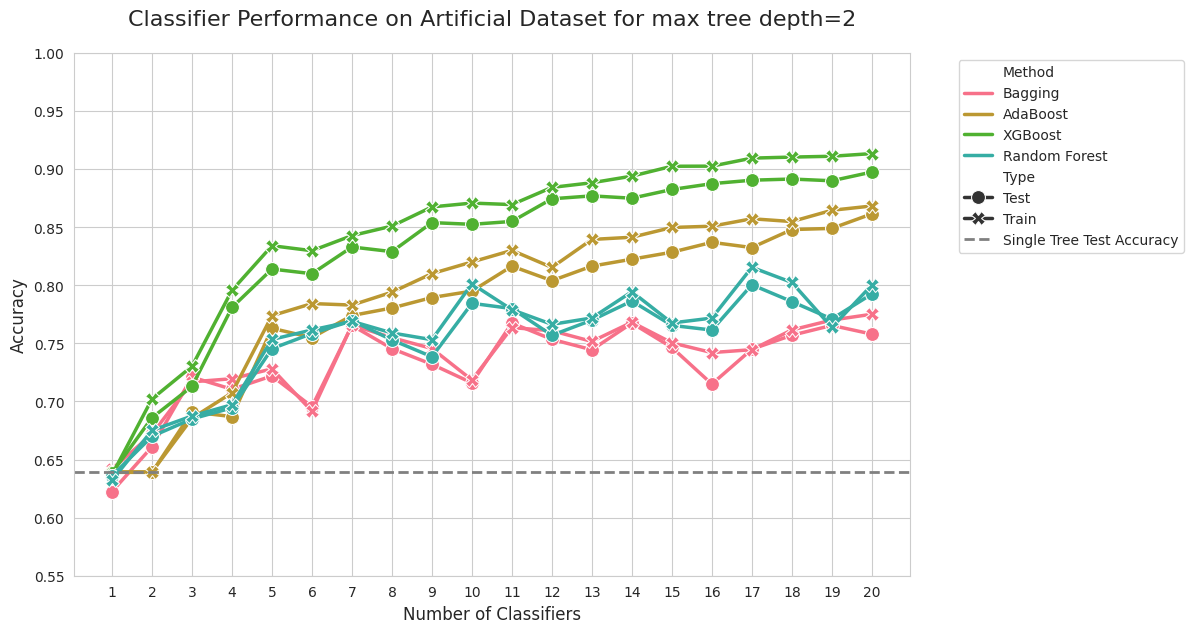

In [51]:
artificial_max_depth=2
data_artificial = eval_classifiers(
    num_classifiers=20, 
    max_depth=artificial_max_depth, 
    X_train=X_artificial_train, 
    X_test=X_artificial_test, 
    y_train=y_artificial_train, 
    y_test=y_artificial_test
    )
plot_data(data_artificial)
plt.title(f'Classifier Performance on Artificial Dataset for max tree depth={artificial_max_depth}', fontsize=16, pad=20)
plt.ylim([0.55, 1])
plt.show()

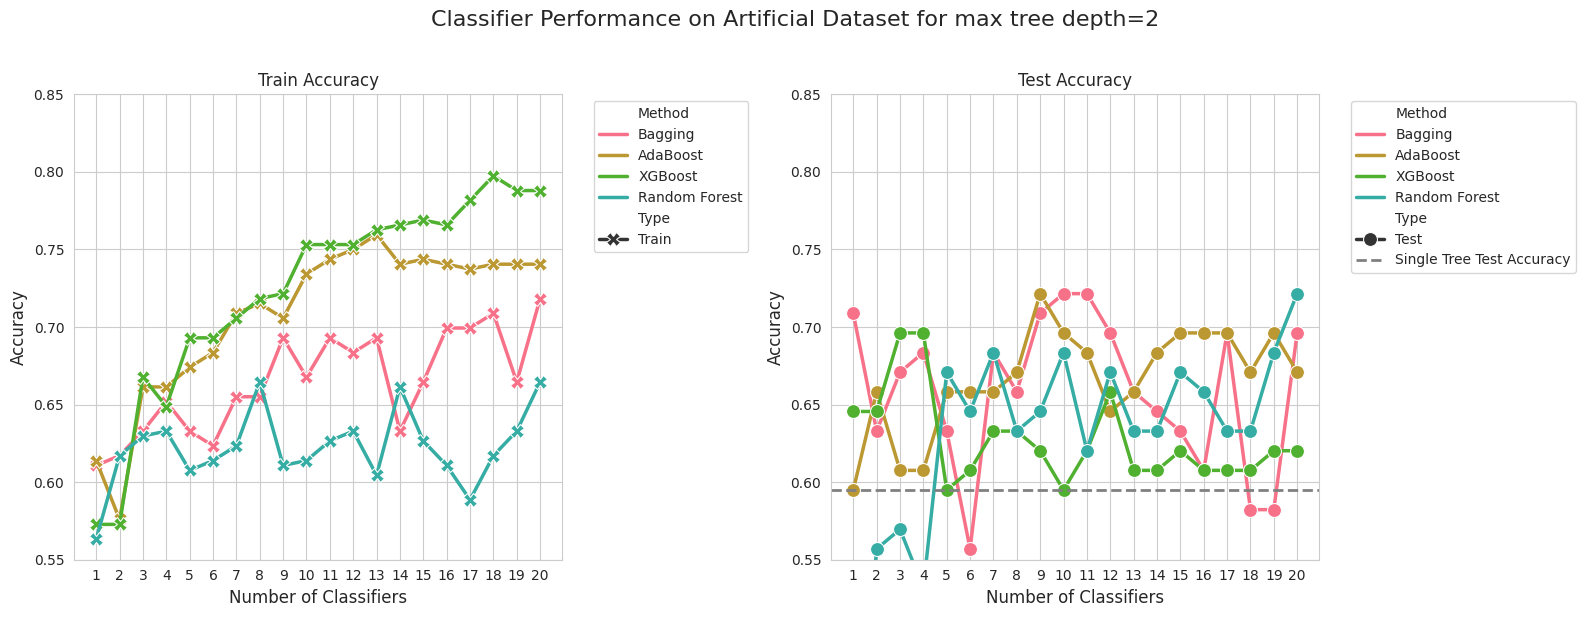

In [52]:
real_max_depth=2
data_real = eval_classifiers(
    num_classifiers=20, 
    max_depth=real_max_depth, 
    X_train=X_real_train, 
    X_test=X_real_test, 
    y_train=y_real_train, 
    y_test=y_real_test
    )
plot_data_separate(data_real, ylim=[0.55, 0.85], main_title=f'Classifier Performance on Artificial Dataset for max tree depth={real_max_depth}')
plt.show()